In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('data/Ridership.csv')
df["Date"] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Day'].astype(str) + '-' + df['Month'].astype(str))
df

,Year,Month,Day,Week Number,Corridor,Workday,Station,Period,Ridership,N_trains,Covid19,Date
0,2019,January,1,1,Corridor_1,n,Station_1,Weekend/Holiday,174,3,0,2019-01-01
1,2019,January,1,1,Corridor_1,n,Station_2,Weekend/Holiday,378,10,0,2019-01-01
2,2019,January,1,1,Corridor_1,n,Station_3,Weekend/Holiday,599,12,0,2019-01-01
3,2019,January,1,1,Corridor_2,n,Station_4,Weekend/Holiday,2759,35,0,2019-01-01
4,2019,January,1,1,Corridor_2,n,Station_5,Weekend/Holiday,2629,36,0,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...
64364,2022,December,31,52,Corridor_3,n,Station_30,Weekend/Holiday,2577,19,0,2022-12-31
64365,2022,December,31,52,Corridor_5,n,Station_19,Weekend/Holiday,74,2,0,2022-12-31
64366,2022,December,31,52,Corridor_7,n,Station_24,Weekend/Holiday,686,12,0,2022-12-31
64367,2022,December,31,52,Corridor_7,n,Station_21,Weekend/Holiday,82,3,0,2022-12-31


As in previous steps, we remove outlier Ridership values and apply Winsorization to reduce the impact of extreme values.


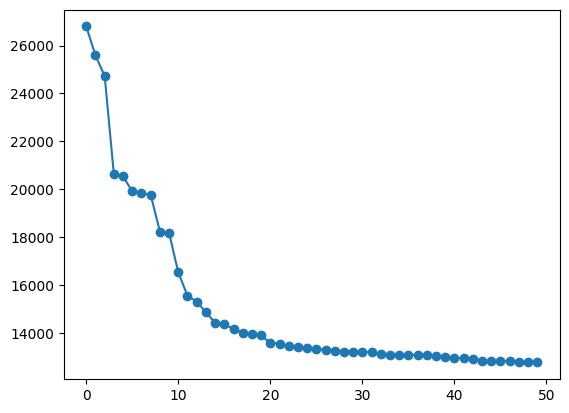

In [3]:
plt.plot(df["Ridership"].sort_values(ascending=False).head(50).reset_index(drop=True), marker='o')
plt.show()

In [4]:
df = df.drop(df["Ridership"].sort_values(ascending=False).head(3).index).reset_index(drop=True)

from scipy.stats.mstats import winsorize
df["Ridership"] = winsorize(df["Ridership"], limits=[0, 8/df["Ridership"].count()])

The start and end dates of the dataset were identified, and for all the days between these two dates, rows were created in the dataset based on "Station", "Corridor", and "Period", regardless of whether there was a value in the table or not. This allows for better control over the time series.


In [5]:
df["Date"].head(1), df["Date"].tail(1)

(0   2019-01-01
 Name: Date, dtype: datetime64[ns],
 64365   2022-12-31
 Name: Date, dtype: datetime64[ns])

In [6]:
full_dates = pd.date_range(start='2019-01-01', end='2022-12-31', freq='D')

unique_groups = df[["Station", "Corridor", "Period"]].drop_duplicates().sort_values(by=["Station", "Corridor", "Period"])

full_index_df = pd.DataFrame([
    (station, corridor, period, date)
    for station, corridor, period in unique_groups.values
    for date in full_dates
], columns=['Station', 'Corridor', 'Period', 'Date'])

df_full = pd.merge(full_index_df, df, on=['Station', 'Corridor', 'Period', 'Date'], how='left')
df_full


,Station,Corridor,Period,Date,Year,Month,Day,Week Number,Workday,Ridership,N_trains,Covid19
0,Station_1,Corridor_1,AM Peak,2019-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Station_1,Corridor_1,AM Peak,2019-01-02,2019.0,January,2.0,1.0,y,3519.0,6.0,0.0
2,Station_1,Corridor_1,AM Peak,2019-01-03,2019.0,January,3.0,1.0,y,3624.0,6.0,0.0
3,Station_1,Corridor_1,AM Peak,2019-01-04,2019.0,January,4.0,1.0,y,3181.0,6.0,0.0
4,Station_1,Corridor_1,AM Peak,2019-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
261514,Station_9,Corridor_4,Weekend/Holiday,2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261515,Station_9,Corridor_4,Weekend/Holiday,2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261516,Station_9,Corridor_4,Weekend/Holiday,2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
261517,Station_9,Corridor_4,Weekend/Holiday,2022-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data was grouped based on "Station", "Corridor", and "Period", and for each group, it was determined what the maximum number of previous days' data was available. In other words, it was concluded that out of the 64,366 available data points, for 60,548 of them, data from 7 days prior is available.


In [7]:
max_lag = 370
df_full_sorted = df_full.sort_values("Date")
grouped = df_full_sorted.groupby(["Station", "Corridor", "Period"])

In [8]:
valid_counts = []

for lag_n in range(max_lag + 1):
    total_valid = 0

    for _, group_df in grouped:
        group_df = group_df.sort_values("Date")
        series = group_df["Ridership"]
        lagged = series.shift(lag_n)

        valid_rows = series.notna() & lagged.notna()
        total_valid += valid_rows.sum()
    
    valid_counts.append(total_valid)

lags = np.arange(max_lag + 1)

lags_summary = pd.DataFrame({
    "Lag": lags,
    "Valid_Record_Count": valid_counts
})

lags_summary.sort_values(by="Valid_Record_Count", ascending=False).reset_index(drop=True)

,Lag,Valid_Record_Count
0,0,64366
1,7,60548
2,14,59604
3,21,58858
4,28,58193
...,...,...
366,354,21201
367,360,21167
368,367,21069
369,361,21045


Based on the ANCOVA test, it was determined that for each record, the highest correlation between its Ridership values and previous days' data is related to the 7th, 14th, 21st, 28th days, and so on.

**AFC (Analysis of Covariance or ANCOVA)** is a statistical test used to compare group means while controlling for the effects of additional variables (covariates). It combines **ANOVA** and **linear regression** to remove the influence of covariates and focus on the main factor of interest.

The weekly correlation is also clearly evident in the chart.



In [9]:
from statsmodels.tsa.stattools import acf

acf_all = []

for _, group_df in grouped:
    ridership_series = group_df["Ridership"].values
    acf_vals = acf(ridership_series, nlags=max_lag, missing='conservative')
    acf_all.append(acf_vals)

acf_array = np.array(acf_all)
acf_mean = np.nanmean(acf_array, axis=0)

lags = np.arange(len(acf_mean))
acf_summary = pd.DataFrame({
    "Lag": lags,
    "Mean_ACF": acf_mean
})

acf_summary.sort_values(by="Mean_ACF", ascending=False).reset_index(drop=True).head(15)

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


,Lag,Mean_ACF
0,0,1.000000
1,7,0.482048
2,14,0.439787
3,21,0.417640
4,28,0.397002
5,1,0.388157
6,35,0.382737
7,42,0.356407
8,49,0.344744
9,6,0.337683


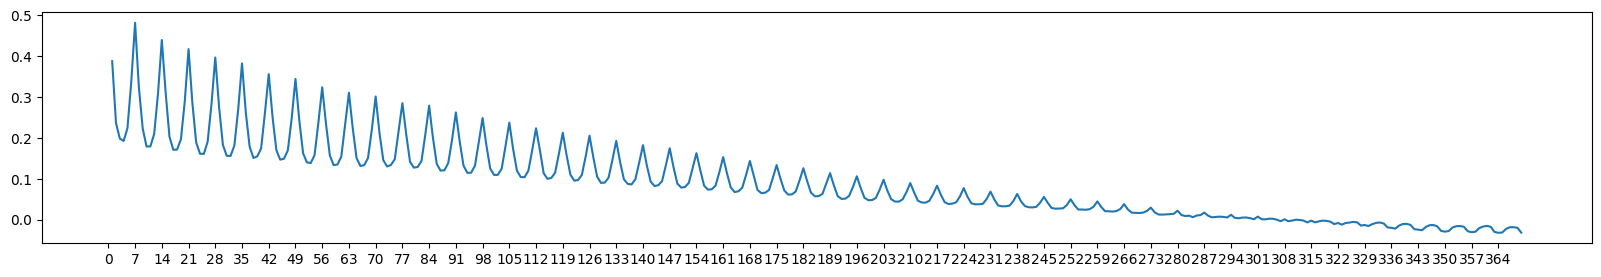

In [10]:
fig, ax = plt.subplots(figsize=(20, 3))
ax = plt.plot(acf_summary['Mean_ACF'].drop(0))
plt.xticks(np.arange(0, 370, 7))
plt.show()

Based on **mutual_info_regression**, the highest correlation between days is observed for days 1, 7, 2, 5, 14, and so on.

**mutual_info_regression** is a method from the `sklearn.feature_selection` module used to measure the dependency between a continuous target variable and input features. It estimates the mutual information, which quantifies the amount of information shared between the features and the target variable. This method can help identify important features for regression tasks by considering both linear and non-linear relationships.



Additionally, the weekly correlation can also be observed in this chart.


In [11]:
from sklearn.feature_selection import mutual_info_regression

mi_all = []

for _, group_df in grouped:
    group_df = group_df.sort_values("Date").copy()
    mi_vals = []

    for lag in range(max_lag + 1):
        if lag == 0:
            mi_vals.append(1)
            continue

        shifted = group_df["Ridership"].shift(lag)
        valid = ~shifted.isna() & ~group_df["Ridership"].isna()

        X = shifted[valid].values.reshape(-1, 1)
        y = group_df["Ridership"][valid].values

        if len(X) > 3: 
            neighbors = min(3, len(X) - 1)
            mi = mutual_info_regression(X, y, discrete_features=False, n_neighbors=neighbors)
            mi_vals.append(mi[0])
        else:
            mi_vals.append(np.nan)

    mi_all.append(mi_vals)


mi_array = np.array(mi_all)
mi_mean = np.nanmean(mi_array, axis=0)
lags = np.arange(len(mi_mean))

mi_summary = pd.DataFrame({
    "Lag": lags,
    "Mean_MI": mi_mean
})

mi_summary.sort_values(by='Mean_MI', ascending=False).reset_index(drop=True).head(15)


,Lag,Mean_MI
0,0,1.000000
1,1,0.958790
2,7,0.936696
3,2,0.909033
4,5,0.832105
5,14,0.827437
6,6,0.825182
7,8,0.794919
8,3,0.776923
9,9,0.766467


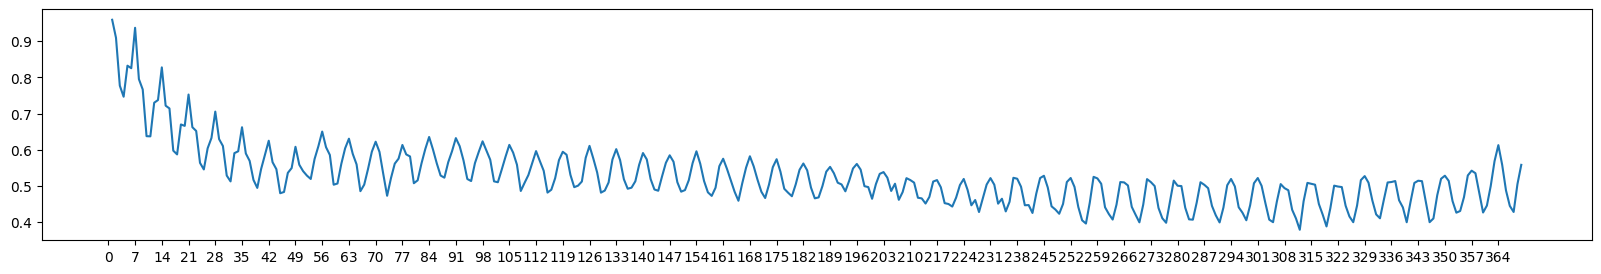

In [12]:
fig, ax = plt.subplots(figsize=(20, 3))
ax = plt.plot(mi_summary['Mean_MI'].drop(0))
plt.xticks(np.arange(0, 370, 7))
plt.show()

Based on the results and the fact that predictions should be made using data from the past week and earlier, the selected lags are 7, 8, 9, 14, 21, and 28.


In [13]:
lag_list = [7, 8, 9, 14, 21, 28]

The required dataset has been created, and as before, feature engineering was performed. The data has been split into three parts: train, validation, and test.


In [14]:
for i in lag_list:
    df_full[f"lag_{i}"] = df_full["Ridership"].shift(i)

df_full = df_full[df_full["Ridership"].notna()]
df_full = df_full.reset_index(drop=True)
df_full.sample(3)

,Station,Corridor,Period,Date,Year,Month,Day,Week Number,Workday,Ridership,N_trains,Covid19,lag_7,lag_8,lag_9,lag_14,lag_21,lag_28
12102,Station_19,Corridor_5,Midday,2021-01-15,2021.0,January,15.0,2.0,y,36.0,1.0,1.0,36.0,33.0,45.0,NaN,NaN,49.0
26490,Station_3,Corridor_2,AM Peak,2020-03-13,2020.0,March,13.0,11.0,y,337.0,12.0,1.0,408.0,439.0,438.0,415.0,404.0,375.0
50070,Station_4,Corridor_3,AM Peak,2022-10-17,2022.0,October,17.0,42.0,y,1383.0,3.0,0.0,NaN,NaN,NaN,1315.0,1254.0,1286.0


In [15]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

def encode_categorical_features(df):

    df['Year'] = df['Year'].astype(int)
    df['Day'] = df['Day'].astype(int)
    df['Weekday_Name'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Day'].astype(str) + '-' + df['Month'].astype(str)).dt.day_name()

    def convert_day_to_circle(day):
        angle = 2 * np.pi * (day - 1) / 31  # Calculate the angle based on the day
        x = np.cos(angle)  # Compute the x-coordinate on the unit circle
        y = np.sin(angle)  # Compute the y-coordinate on the unit circle
        return x, y


    categorical_features = ['Month', 'Corridor', 'Station', 'Period', 'Weekday_Name']

    df['day_x'], df['day_y'] = zip(*df['Day'].map(convert_day_to_circle))
    X = df.drop(columns=['Ridership', 'Day', 'Year', 'Workday', 'N_trains', 'Date'], axis=1)  # Features (excluding the target column) and also Day which is already converted

    # Create a ColumnTransformer to apply OneHotEncoder to categorical features
    preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(), categorical_features), 
    ],
    remainder='passthrough'
    )

    # Apply the ColumnTransformer to encode categorical features
    X_encoded = preprocessor.fit_transform(X)

    # Convert the encoded features to a dense matrix
    X_encoded = X_encoded.toarray()

    feature_names_out = list(preprocessor.get_feature_names_out())
    # Convert the dense matrix to a DataFrame
    X_encoded = pd.DataFrame(X_encoded, columns=[item.split('__')[1] for item in feature_names_out])

    return X_encoded

In [16]:
# Since we're trying to predict the ridership for different stations we have to apply the 80% to each of the stations separately

def split_the_timeseries_data(df, X_encoded):
    # Create empty lists to store the train-test split data
    X_train = []
    X_val = []
    X_test = []
    y_train = []
    y_val = []
    y_test = []


    # Iterate over each unique station
    for station in df['Station'].unique():
        # Get the data for the current station
        station_data = X_encoded[X_encoded['Station_'+station] == 1]
        target_data = df.loc[X_encoded['Station_'+station] == 1, 'Ridership']

        # Determine the number of samples to include in the test set
        test_size = int(len(station_data) * 0.15)

        # Split the data into trainval and test sets
        station_X_trainval = station_data[:-test_size]
        station_X_test = station_data[-test_size:]
        station_y_trainval = target_data[:-test_size]
        station_y_test = target_data[-test_size:]

        # Determine the number of samples to include in the val set
        val_size = int(len(station_X_trainval) * 0.15)

        # Split the data into train and val sets
        station_X_train = station_X_trainval[:-val_size]
        station_X_val = station_X_trainval[-val_size:]
        station_y_train = station_y_trainval[:-val_size]
        station_y_val = station_y_trainval[-val_size:]

        # Append the station-specific data to the overall train-test split
        X_train.append(station_X_train)
        X_val.append(station_X_val)
        X_test.append(station_X_test)
        y_train.append(station_y_train)
        y_val.append(station_y_val)
        y_test.append(station_y_test)

    # Concatenate the train-test split data
    X_train = pd.concat(X_train)
    X_val = pd.concat(X_val)
    X_test = pd.concat(X_test)
    y_train = pd.concat(y_train)
    y_val = pd.concat(y_val)
    y_test = pd.concat(y_test)

    return X_train, X_val ,X_test, y_train, y_val, y_test

To determine the best strategy for filling null values in the lag features (i.e., values from previous days), three different methods were tested:

1. Filling missing values with `-1`
2. Filling missing values with the `mean` of other available values
3. Filling missing values using the **nearest neighbor** approach `(KNN impute)`


## Filling Missing Lag Values with -1

In this approach, any lag with missing values is replaced with `-1`, while for other columns that have values (such as the **Ridership** column), the logarithm is applied to them.


In [17]:
df_full_mines1 = df_full.copy()

In [18]:
for i in lag_list:
    df_full_mines1[f"lag_{i}"] = df_full_mines1[f"lag_{i}"].fillna(-1)

In [19]:
for i in lag_list:
    df_full_mines1.loc[df_full_mines1[f"lag_{i}"] != -1, f"lag_{i}"] = np.log1p(df_full_mines1[f"lag_{i}"])
df_full_mines1['Ridership'] = np.log1p(df_full_mines1['Ridership'])

c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\eftekhari\Desktop\DataScienseTest\Chapter4\myenv\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1

In [20]:
X_encoded = encode_categorical_features(df_full_mines1)
X_train, X_val ,X_test, y_train, y_val, y_test = split_the_timeseries_data(df_full_mines1, X_encoded)

In [21]:
for i in lag_list:
    X_train[f'lag_{i}_missing'] = (X_train[f'lag_{i}'] == -1).astype(int)
    X_val[f'lag_{i}_missing'] = (X_val[f'lag_{i}'] == -1).astype(int)
    X_test[f'lag_{i}_missing'] = (X_test[f'lag_{i}'] == -1).astype(int)

In [22]:
print("Train shape:", X_train.shape)
print("val  shape:", X_val.shape)
print("Test  shape:", X_test.shape)

Train shape: (46516, 92)
val  shape: (8192, 92)
Test  shape: (9658, 92)


In [23]:
X_train.columns

Index(['Month_April', 'Month_August', 'Month_December', 'Month_February',
       'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September',
       'Corridor_Corridor_1', 'Corridor_Corridor_2', 'Corridor_Corridor_3',
       'Corridor_Corridor_4', 'Corridor_Corridor_5', 'Corridor_Corridor_6',
       'Corridor_Corridor_7', 'Station_Station_1', 'Station_Station_10',
       'Station_Station_11', 'Station_Station_12', 'Station_Station_13',
       'Station_Station_14', 'Station_Station_15', 'Station_Station_16',
       'Station_Station_17', 'Station_Station_18', 'Station_Station_19',
       'Station_Station_2', 'Station_Station_20', 'Station_Station_21',
       'Station_Station_22', 'Station_Station_23', 'Station_Station_24',
       'Station_Station_25', 'Station_Station_26', 'Station_Station_27',
       'Station_Station_28', 'Station_Station_29', 'Station_Station_3',
       'Station_Station_30', 'Station_Station_31', 

In [24]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train['Week Number'] = scaler.fit_transform(X_train[['Week Number']])
X_val['Week Number'] = scaler.transform(X_val[['Week Number']])
X_test['Week Number'] = scaler.transform(X_test[['Week Number']])


In [25]:
X_train.to_csv("data\Q2\\fill_mines1\X_train.csv", index=False)
X_test.to_csv("data\Q2\\fill_mines1\X_test.csv", index=False)
X_val.to_csv("data\Q2\\fill_mines1\X_val.csv", index=False)
y_train.to_csv("data\Q2\\fill_mines1\y_train.csv", index=False)
y_test.to_csv("data\Q2\\fill_mines1\y_test.csv", index=False)
y_val.to_csv("data\Q2\\fill_mines1\y_val.csv", index=False)

## Filling Missing Lag Values with Mean

In this approach, the missing values in the lag features were imputed using the mean of the available values.  
The mean was calculated using a **grouped aggregation**, so that for each specific group, the corresponding group-wise mean was used to fill in the null values.  
Details on how the grouping was performed will be provided in the following sections.

In [26]:
df_full_mean = df_full.copy()

First, the `Ridership` column and all lag columns are transformed using the natural logarithm.  
Then, the dataset is split into three parts: **train**, **validation**, and **test**.


In [27]:
for i in lag_list:
    df_full_mean[f"lag_{i}"] = np.log1p(df_full_mean[f"lag_{i}"])
df_full_mean['Ridership'] = np.log1p(df_full_mean['Ridership'])

In [28]:
X_encoded = encode_categorical_features(df_full_mean)
X_train, X_val ,X_test, y_train, y_val, y_test = split_the_timeseries_data(df_full_mean, X_encoded)

As seen, there are a significant number of null values that require an intelligent mean imputation approach.


In [29]:
def check_remaining_nans(df, lag_list, name=""):
    print(f"--- Null counts in {name} ---")
    for lag in lag_list:
        col = f"lag_{lag}"
        null_count = df[col].isna().sum()
        print(f"{col}: {null_count}")

check_remaining_nans(X_train, lag_list, "X_train")
check_remaining_nans(X_val, lag_list, "X_val")
check_remaining_nans(X_test, lag_list, "X_test")

--- Null counts in X_train ---
lag_7: 2465
lag_8: 10947
lag_9: 20528
lag_14: 3097
lag_21: 3569
lag_28: 3978
--- Null counts in X_val ---
lag_7: 378
lag_8: 1866
lag_9: 3540
lag_14: 455
lag_21: 488
lag_28: 523
--- Null counts in X_test ---
lag_7: 919
lag_8: 3026
lag_9: 5412
lag_14: 1060
lag_21: 1213
lag_28: 1339


***Step 1: Calculating Group-wise Means for Lag Columns***

In this step, we aim to fill the missing values (null values) in the "lag" columns of our dataset using group-wise means. The "lags" represent past values that help in time series prediction. We calculate the mean for each "lag" within groups defined by specific combinations of features like **Station**, **Corridor**, **Period**, and **Covid19**.

The reason we use group-wise means is to ensure that each missing value in a lag column is filled based on similar groups of data, improving consistency in the dataset.

Here’s how the code works:

1. It first identifies all columns related to **Station**, **Corridor**, and **Period**.
    - **Station columns**: `Station_1, Station_2, Station_3, ...`
    - **Corridor columns**: `Corridor_1, Corridor_2, Corridor_3, ...`
    - **Period columns**: `Period_Morning, Period_Afternoon, Period_Evening`
   
2. Then, it iterates through all possible combinations of these columns and calculates the mean for each lag feature.
    - For each group (combination of Station, Corridor, Period, and Covid19), the mean of each lag column is calculated (e.g., lag_7, lag_14, lag_21).

3. The result is stored in a dictionary, where:
    - **Key**: A tuple of the form `(station_col, corridor_col, period_col, covid_val, col_name)`.
    - **Value**: The corresponding mean for that group.

4. Later, we use this dictionary to replace the missing values (nulls) with the appropriate mean values in the dataset.

The process ensures that we maintain the structure and behavior of the time series data while handling the missing values appropriately.


In [30]:
station_list = [col for col in X_train.columns if col.startswith('Station_')]
corridor_list = [col for col in X_train.columns if col.startswith('Corridor_')]
period_list = [col for col in X_train.columns if col.startswith('Period_')]

group_lag_means = {}

for station_col in station_list:
    for corridor_col in corridor_list:
        for period_col in period_list:
            for covid_val in [0, 1]:
                mask = (X_train[station_col] == 1) & \
                       (X_train[corridor_col] == 1) & \
                       (X_train[period_col] == 1) & \
                       (X_train['Covid19'] == covid_val)
                
                for lag in lag_list:
                    col_name = f'lag_{lag}'
                    subset = X_train[mask]
                    mean_val = subset[col_name].mean() if not subset.empty else None
                    key = (station_col, corridor_col, period_col, covid_val, col_name)
                    group_lag_means[key] = mean_val

def fill_lag_nans_with_group_means(df, group_lag_means):
    df_filled = df.copy()
    for lag in lag_list:
        col_name = f'lag_{lag}'
        null_indices = df_filled[df_filled[col_name].isna()].index

        for idx in null_indices:
            covid_val = df_filled.loc[idx, 'Covid19']
            
            station_col = [col for col in station_list if df_filled.loc[idx, col] == 1][0]
            corridor_col = [col for col in corridor_list if df_filled.loc[idx, col] == 1][0]
            period_col = [col for col in period_list if df_filled.loc[idx, col] == 1][0]
            
            key = (station_col, corridor_col, period_col, covid_val, col_name)
            mean_val = group_lag_means.get(key)
            
            if mean_val is not None:
                df_filled.at[idx, col_name] = mean_val

    return df_filled


In [31]:
X_train_filled = fill_lag_nans_with_group_means(X_train, group_lag_means)
X_val_filled = fill_lag_nans_with_group_means(X_val, group_lag_means)
X_test_filled = fill_lag_nans_with_group_means(X_test, group_lag_means)


check_remaining_nans(X_train_filled, lag_list, "X_train")
check_remaining_nans(X_val_filled, lag_list, "X_val")
check_remaining_nans(X_test_filled, lag_list, "X_test")

--- Null counts in X_train ---
lag_7: 63
lag_8: 65
lag_9: 65
lag_14: 65
lag_21: 90
lag_28: 95
--- Null counts in X_val ---
lag_7: 209
lag_8: 929
lag_9: 1752
lag_14: 246
lag_21: 281
lag_28: 323
--- Null counts in X_test ---
lag_7: 808
lag_8: 2525
lag_9: 4465
lag_14: 932
lag_21: 1079
lag_28: 1208


In this section, it was examined whether for each specific **lag**, in different stations, lines, and time periods, the **ridership** value was missing during **Covid19 == 1** (when COVID conditions were present) but available during **Covid19 == 0** (when COVID conditions were not present).

For this purpose, if for a specific **lag**, the **ridership** value was missing during COVID but available during non-COVID times, this **lag** was identified as one that could potentially be used for filling missing values.

However, no records with these conditions were found.


In [ ]:
from collections import defaultdict

def count_nan_fillable_groups(X, lag_list):
    fillable_counts = defaultdict(int)
    
    station_list = [s.replace('Station_', '') for s in X.columns if s.startswith('Station_')]
    corridor_list = [c.replace('Corridor_', '') for c in X.columns if c.startswith('Corridor_')]
    period_list = [p.replace('Period_', '') for p in X.columns if p.startswith('Period_')]

    for lag in lag_list:
        col = f'lag_{lag}'
        for station in station_list:
            for corridor in corridor_list:
                for period in period_list:

                    mask_group = (
                        (X.get(f'Station_{station}', 0) == 1) &
                        (X.get(f'Corridor_{corridor}', 0) == 1) &
                        (X.get(f'Period_{period}', 0) == 1)
                    )

                    group_c1 = X[mask_group & (X['Covid19'] == 1)]
                    group_c0 = X[mask_group & (X['Covid19'] == 0)]
                    
                    if group_c1[col].isna().any() and group_c0[col].notna().any():
                        fillable_counts[lag] += 1
                        
    return dict(fillable_counts)


In [33]:
fillable = count_nan_fillable_groups(X_train, lag_list)
print("number of group for each lag:")
for lag, count in fillable.items():
    print(f"lag_{lag}: {count}")


number of group for each lag:


***Step 2: Calculating Group-wise Means for Lag Columns Based on Station and Period***  

In this step, we aim to fill the missing values (null values) in the "lag" columns by calculating group-wise means based on the combination of **Station**, **Period**, and **Covid19** values. This approach helps ensure that missing lag values are filled based on past data from the same station, period, and the Covid19 situation (either with or without Covid).

Here’s how the code works:

1. It first identifies all columns related to **Station** and **Period**.
    - **Station columns**: `Station_1, Station_2, Station_3, ...`
    - **Period columns**: `Period_Morning, Period_Afternoon, Period_Evening`
   
2. Then, it iterates through all possible combinations of **Station** and **Period**, as well as the two values of **Covid19** (0 or 1), to calculate the mean for each lag feature (e.g., lag_7, lag_14, lag_21).

3. The mean for each lag column is stored in a dictionary:
    - **Key**: A tuple of the form `(station_col, period_col, covid_val, col_name)`.
    - **Value**: The mean value for the corresponding group.

4. Finally, this dictionary is used to fill missing values in the dataset by replacing them with the calculated group-wise means.

The process ensures that the missing values are filled based on similar groups, maintaining the consistency of the time series data.


In [34]:
group_lag_means = {}

for station_col in station_list:
        for period_col in period_list:
            for covid_val in [0, 1]:
                mask = (X_train[station_col] == 1) & \
                       (X_train[period_col] == 1) & \
                       (X_train['Covid19'] == covid_val)
                
                for lag in lag_list:
                    col_name = f'lag_{lag}'
                    subset = X_train[mask]
                    mean_val = subset[col_name].mean() if not subset.empty else None
                    key = (station_col, period_col, covid_val, col_name)
                    group_lag_means[key] = mean_val

def fill_lag_nans_with_group_means(df, group_lag_means):
    df_filled = df.copy()
    for lag in lag_list:
        col_name = f'lag_{lag}'
        null_indices = df_filled[df_filled[col_name].isna()].index

        for idx in null_indices:
            covid_val = df_filled.loc[idx, 'Covid19']
            
            station_col = [col for col in station_list if df_filled.loc[idx, col] == 1][0]
            period_col = [col for col in period_list if df_filled.loc[idx, col] == 1][0]
            
            key = (station_col, period_col, covid_val, col_name)
            mean_val = group_lag_means.get(key)
            
            if mean_val is not None:
                df_filled.at[idx, col_name] = mean_val

    return df_filled

In [35]:
X_train_filled = fill_lag_nans_with_group_means(X_train_filled, group_lag_means)
X_val_filled = fill_lag_nans_with_group_means(X_val_filled, group_lag_means)
X_test_filled = fill_lag_nans_with_group_means(X_test_filled, group_lag_means)


check_remaining_nans(X_train_filled, lag_list, "X_train")
check_remaining_nans(X_val_filled, lag_list, "X_val")
check_remaining_nans(X_test_filled, lag_list, "X_test")

--- Null counts in X_train ---
lag_7: 46
lag_8: 48
lag_9: 48
lag_14: 62
lag_21: 75
lag_28: 92
--- Null counts in X_val ---
lag_7: 69
lag_8: 265
lag_9: 495
lag_14: 86
lag_21: 101
lag_28: 124
--- Null counts in X_test ---
lag_7: 563
lag_8: 1509
lag_9: 2576
lag_14: 638
lag_21: 731
lag_28: 812



***Step 3: Calculating Group-wise Means for Lag Columns Based on Station and Covid19***  

In this step, we focus on calculating group-wise means for the "lag" columns based on the combination of **Station** and **Covid19** values. This step ensures that we handle missing lag values in a way that reflects the station's data and whether Covid19 was present (0 or 1).

Here’s how the code works:

1. It first identifies all columns related to **Station**.
    - **Station columns**: `Station_1, Station_2, Station_3, ...`
   
2. Then, it iterates through all possible combinations of **Station** and **Covid19** values (0 or 1) to calculate the mean for each lag feature (e.g., lag_7, lag_14, lag_21).

3. The mean for each lag column is stored in a dictionary:
    - **Key**: A tuple of the form `(station_col, covid_val, col_name)`.
    - **Value**: The mean value for that group.

4. Later, this dictionary is used to replace missing values in the dataset by filling them with the appropriate group-wise means based on the station and Covid19 status.

This step ensures that the time series data remains consistent by using relevant group-wise means for each station and Covid19 scenario, allowing for more accurate filling of missing values.

In [36]:
group_lag_means = {}

for station_col in station_list:
            for covid_val in [0, 1]:
                mask = (X_train[station_col] == 1) & \
                       (X_train['Covid19'] == covid_val)
                
                for lag in lag_list:
                    col_name = f'lag_{lag}'
                    subset = X_train[mask]
                    mean_val = subset[col_name].mean() if not subset.empty else None
                    key = (station_col, covid_val, col_name)
                    group_lag_means[key] = mean_val

def fill_lag_nans_with_group_means(df, group_lag_means):
    df_filled = df.copy()
    for lag in lag_list:
        col_name = f'lag_{lag}'
        null_indices = df_filled[df_filled[col_name].isna()].index

        for idx in null_indices:
            covid_val = df_filled.loc[idx, 'Covid19']
            
            station_col = [col for col in station_list if df_filled.loc[idx, col] == 1][0]
            
            key = (station_col, covid_val, col_name)
            mean_val = group_lag_means.get(key)
            
            if mean_val is not None:
                df_filled.at[idx, col_name] = mean_val

    return df_filled

In [37]:
X_train_filled = fill_lag_nans_with_group_means(X_train_filled, group_lag_means)
X_val_filled = fill_lag_nans_with_group_means(X_val_filled, group_lag_means)
X_test_filled = fill_lag_nans_with_group_means(X_test_filled, group_lag_means)


check_remaining_nans(X_train_filled, lag_list, "X_train")
check_remaining_nans(X_val_filled, lag_list, "X_val")
check_remaining_nans(X_test_filled, lag_list, "X_test")

--- Null counts in X_train ---
lag_7: 25
lag_8: 31
lag_9: 31
lag_14: 38
lag_21: 55
lag_28: 31
--- Null counts in X_val ---
lag_7: 3
lag_8: 7
lag_9: 12
lag_14: 6
lag_21: 8
lag_28: 6
--- Null counts in X_test ---
lag_7: 37
lag_8: 55
lag_9: 77
lag_14: 38
lag_21: 45
lag_28: 46


In the final step, any rows that still contain null values in their columns are removed from the dataset. Since the number of such rows is relatively small, this removal will not significantly affect the overall dataset. This ensures that only complete data is used for further analysis or modeling, improving the quality and consistency of the dataset.

Here's how the process works:

1. After filling the missing values in the lag columns with group-wise means, we check if any null values still remain in any of the columns.
   
2. Rows with any null values are identified and removed from the dataset.

3. The remaining dataset now contains only complete data, ready for further analysis or model training.

This final step helps ensure the integrity of the dataset by removing incomplete rows, which is particularly important when preparing data for machine learning models where missing values can negatively impact performance.

In [38]:
X_train = X_train_filled.dropna()
train_indices_to_drop = X_train_filled.index.difference(X_train.index)
y_train = y_train.drop(train_indices_to_drop)

X_val = X_val_filled.dropna()
val_indices_to_drop = X_val_filled.index.difference(X_val.index)
y_val = y_val.drop(val_indices_to_drop)

X_test = X_test_filled.dropna()
test_indices_to_drop = X_test_filled.index.difference(X_test.index)
y_test = y_test.drop(test_indices_to_drop)


In [39]:
print("Train shape:", X_train.shape)
print("val  shape:", X_val.shape)
print("Test  shape:", X_test.shape)

Train shape: (46461, 86)
val  shape: (8173, 86)
Test  shape: (9568, 86)


In [40]:
X_train.columns

Index(['Month_April', 'Month_August', 'Month_December', 'Month_February',
       'Month_January', 'Month_July', 'Month_June', 'Month_March', 'Month_May',
       'Month_November', 'Month_October', 'Month_September',
       'Corridor_Corridor_1', 'Corridor_Corridor_2', 'Corridor_Corridor_3',
       'Corridor_Corridor_4', 'Corridor_Corridor_5', 'Corridor_Corridor_6',
       'Corridor_Corridor_7', 'Station_Station_1', 'Station_Station_10',
       'Station_Station_11', 'Station_Station_12', 'Station_Station_13',
       'Station_Station_14', 'Station_Station_15', 'Station_Station_16',
       'Station_Station_17', 'Station_Station_18', 'Station_Station_19',
       'Station_Station_2', 'Station_Station_20', 'Station_Station_21',
       'Station_Station_22', 'Station_Station_23', 'Station_Station_24',
       'Station_Station_25', 'Station_Station_26', 'Station_Station_27',
       'Station_Station_28', 'Station_Station_29', 'Station_Station_3',
       'Station_Station_30', 'Station_Station_31', 

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train['Week Number'] = scaler.fit_transform(X_train[['Week Number']])
X_val['Week Number'] = scaler.transform(X_val[['Week Number']])
X_test['Week Number'] = scaler.transform(X_test[['Week Number']])

C:\Users\eftekhari\AppData\Local\Temp\ipykernel_3224\743212509.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Week Number'] = scaler.fit_transform(X_train[['Week Number']])
C:\Users\eftekhari\AppData\Local\Temp\ipykernel_3224\743212509.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['Week Number'] = scaler.transform(X_val[['Week Number']])
C:\Users\eftekhari\AppData\Local\Temp\ipykernel_3224\743212509.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fro

In [42]:
X_train.to_csv("data\Q2\\fill_mean\X_train.csv", index=False)
X_test.to_csv("data\Q2\\fill_mean\X_test.csv", index=False)
X_val.to_csv("data\Q2\\fill_mean\X_val.csv", index=False)
y_train.to_csv("data\Q2\\fill_mean\y_train.csv", index=False)
y_test.to_csv("data\Q2\\fill_mean\y_test.csv", index=False)
y_val.to_csv("data\Q2\\fill_mean\y_val.csv", index=False)

## Filling Missing Lag Values with KNN Imputation



In this method, **Ridership** and **lag** columns are first transformed logarithmically. Then, for each **lag**, a KNN imputation is performed under both **Covid** and **non-Covid** conditions to fill the null values. There are a few points regarding this method:

1. The reason for separating the data into **Covid** and **non-Covid** is due to the significant difference that **Covid** creates.
2. The training was done only on the non-null data from the **train dataset**, and the best hyperparameters were found using the non-null data from the **val** and **test datasets**.
3. To make the predictions more accurate and realistic, only the null values in the **train dataset** were filled, while the rows with null values in the **val** and **test datasets** were removed.


In [74]:
df_full_knn = df_full.copy()

In [75]:
for i in lag_list:
    df_full_knn[f"lag_{i}"] = np.log1p(df_full_knn[f"lag_{i}"])
df_full_knn['Ridership'] = np.log1p(df_full_knn['Ridership'])

In [76]:
X_encoded = encode_categorical_features(df_full_knn)
X_train, X_val ,X_test, y_train, y_val, y_test = split_the_timeseries_data(df_full_knn, X_encoded)

In [77]:
x_index = X_val.copy()
X_val = X_val.dropna()
val_indices_to_drop = x_index.index.difference(X_val.index)
y_val = y_val.drop(val_indices_to_drop)
print("val:", X_val.shape, y_val.shape)

x_index = X_test.copy()
X_test = X_test.dropna()
test_indices_to_drop = x_index.index.difference(X_test.index)
y_test = y_test.drop(test_indices_to_drop)
print("test:", X_test.shape, y_test.shape)


val: (4175, 86) (4175,)
test: (3613, 86) (3613,)


In [78]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

def run_knn_imputation(X_train, X_val, X_test, y_train, y_val, y_test, lag_list):

    X_train = X_train.copy()
    X_val = X_val.copy()
    X_test = X_test.copy()

    X_train['Ridership'] = y_train
    X_val['Ridership'] = y_val
    X_test['Ridership'] = y_test 

    feature_cols = [col for col in X_train.columns if not col.startswith('lag_')]

    for lag in lag_list:
        lag_col = f"lag_{lag}"

        train_with_val = X_train[X_train[lag_col].notna()]
        train_missing = X_train[X_train[lag_col].isna()]

        if train_with_val.empty:
            print(f"Skipping {lag_col}, no available training data.")
            continue

        X_train_model = train_with_val[feature_cols].copy()
        y_train_model = train_with_val[lag_col]

        X_val_model = X_val[feature_cols].copy()
        y_val_model = X_val[lag_col]

        X_test_model = X_test[feature_cols].copy()
        y_test_model = X_test[lag_col]

        X_combined = pd.concat([X_train_model, X_val_model, X_test_model])
        y_combined = pd.concat([y_train_model, y_val_model, y_test_model])

        train_indices = np.arange(len(X_train_model))
        val_test_indices = np.arange(len(X_train_model), len(X_combined))
        cv_split = [(train_indices, val_test_indices)]

        knn = KNeighborsRegressor()
        param_grid = {
            'n_neighbors': np.arange(1, 51),
            'weights': ['uniform', 'distance'],
            'metric': ['minkowski'],
            'p': [1, 2],
        }
        grid = GridSearchCV(knn, param_grid, cv=cv_split, scoring='neg_mean_squared_error', n_jobs=8)
        grid.fit(X_combined, y_combined)

        best_knn = grid.best_estimator_
        print(f"Best KNN for {lag_col}: {grid.best_params_}")

        if not train_missing.empty:
            X_pred_features = train_missing[feature_cols].copy()
            preds = best_knn.predict(X_pred_features)
            X_train.loc[train_missing.index, lag_col] = preds

    return X_train


In [80]:
X_train_covid = X_train[X_train['Covid19'] == 1]
X_val_covid = X_val[X_val['Covid19'] == 1]
X_test_covid = X_test[X_test['Covid19'] == 1]
y_train_covid = y_train.loc[X_train_covid.index]
y_val_covid = y_val.loc[X_val_covid.index]
y_test_covid = y_test.loc[X_test_covid.index]

X_train_noncovid = X_train[X_train['Covid19'] == 0]
X_val_noncovid = X_val[X_val['Covid19'] == 0]
X_test_noncovid = X_test[X_test['Covid19'] == 0]
y_train_noncovid = y_train.loc[X_train_noncovid.index]
y_val_noncovid = y_val.loc[X_val_noncovid.index]
y_test_noncovid = y_test.loc[X_test_noncovid.index]

print("==== Imputing for Covid19 is 1 ====")
X_train_covid_filled = run_knn_imputation( X_train_covid, X_val_covid, X_test_covid,
                                           y_train_covid, y_val_covid, y_test_covid, lag_list)

print("==== Imputing for Covid19 is 0 ====")
X_train_noncovid_filled = run_knn_imputation(X_train_noncovid, X_val_noncovid, X_test_noncovid, 
                                             y_train_noncovid, y_val_noncovid, y_test_noncovid, lag_list)

X_train.loc[X_train_covid.index] = X_train_covid_filled

X_train.loc[X_train_noncovid.index] = X_train_noncovid_filled


==== Imputing for Covid19 is 1 ====
Best KNN for lag_7: {'metric': 'minkowski', 'n_neighbors': 17, 'p': 2, 'weights': 'distance'}
Best KNN for lag_8: {'metric': 'minkowski', 'n_neighbors': 24, 'p': 2, 'weights': 'distance'}
Best KNN for lag_9: {'metric': 'minkowski', 'n_neighbors': 18, 'p': 2, 'weights': 'distance'}
Best KNN for lag_14: {'metric': 'minkowski', 'n_neighbors': 21, 'p': 2, 'weights': 'distance'}
Best KNN for lag_21: {'metric': 'minkowski', 'n_neighbors': 16, 'p': 2, 'weights': 'uniform'}
Best KNN for lag_28: {'metric': 'minkowski', 'n_neighbors': 18, 'p': 2, 'weights': 'uniform'}
==== Imputing for Covid19 is 0 ====
Best KNN for lag_7: {'metric': 'minkowski', 'n_neighbors': 17, 'p': 2, 'weights': 'uniform'}
Best KNN for lag_8: {'metric': 'minkowski', 'n_neighbors': 16, 'p': 2, 'weights': 'distance'}
Best KNN for lag_9: {'metric': 'minkowski', 'n_neighbors': 13, 'p': 2, 'weights': 'distance'}
Best KNN for lag_14: {'metric': 'minkowski', 'n_neighbors': 17, 'p': 2, 'weights':

In [81]:
X_train.isnull().sum().sum(), X_val.isnull().sum().sum(), X_test.isnull().sum().sum()

(0, 0, 0)

In [82]:
print("Train shape:", X_train.shape)
print("val  shape:", X_val.shape)
print("Test  shape:", X_test.shape)

Train shape: (46516, 86)
val  shape: (4175, 86)
Test  shape: (3613, 86)


In [83]:
print("Train shape:", y_train.shape)
print("val  shape:", y_val.shape)
print("Test  shape:", y_test.shape)

Train shape: (46516,)
val  shape: (4175,)
Test  shape: (3613,)


In [84]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train['Week Number'] = scaler.fit_transform(X_train[['Week Number']])
X_val['Week Number'] = scaler.transform(X_val[['Week Number']])
X_test['Week Number'] = scaler.transform(X_test[['Week Number']])


In [85]:
X_train.to_csv("data\Q2\\fill_knn\X_train.csv", index=False)
X_test.to_csv("data\Q2\\fill_knn\X_test.csv", index=False)
X_val.to_csv("data\Q2\\fill_knn\X_val.csv", index=False)
y_train.to_csv("data\Q2\\fill_knn\y_train.csv", index=False)
y_test.to_csv("data\Q2\\fill_knn\y_test.csv", index=False)
y_val.to_csv("data\Q2\\fill_knn\y_val.csv", index=False)